In [16]:
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    get_tuids_containing,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [17]:
from qce_utils.addon_quantify.object_factories.factory_photon_depletion import PhotonDepletionFactory
from qce_utils.control_interfaces.datastorage_control.analysis_factories.factory_photon_depletion import (
    PhotonDepletionAnalysis as PhotonDepletionAnalysis_,
    IPhotonDepletionContainer,
    FigureContainer,
)

from qce_utils.addon_quantify.deserialize_xarray_to_obj import DeserializeBootstrap

object_factory = PhotonDepletionFactory()

In [18]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [19]:
tuid = get_latest_tuid(contains="Photon depletion") 
dataset = load_dataset(tuid)

In [20]:
dataset_bootstrap = DeserializeBootstrap(data=dataset)
data_object: IPhotonDepletionContainer = object_factory.construct(dataset_bootstrap)

[[ 8.20069315e-03  4.49724641e-01  3.57215501e-01  4.39757028e-01]
 [ 1.21756325e-02  4.20185885e-01  3.70803277e-01  3.87262932e-01]
 [ 5.07581299e-04  4.15174655e-01  3.32169587e-01  3.80036644e-01]
 [ 1.62340293e-02  4.14202212e-01  3.64230332e-01  4.28007012e-01]
 [-5.72466558e-03  4.08251262e-01  3.28931920e-01  4.01377462e-01]
 [ 7.91060248e-03  4.11977892e-01  3.53766047e-01  3.74565834e-01]
 [-2.25198221e-03  4.39063987e-01  5.37011982e-01  5.05807829e-01]
 [-4.00594005e-03  3.37299995e-01  6.40009262e-01  9.43210298e-01]
 [-7.43331167e-03  4.77216233e-01  5.20858440e-01  9.97266951e-01]
 [-3.72061204e-03  4.84173208e-01  5.05790125e-01  1.00444888e+00]
 [-2.37616879e-03  4.93992626e-01  4.83839305e-01  1.01441509e+00]
 [ 4.15622045e-03  5.17847175e-01  4.95259866e-01  9.99262624e-01]
 [-1.38736958e-02  5.04380384e-01  4.72656339e-01  1.00605672e+00]
 [ 6.26393681e-03  5.00250815e-01  4.63233862e-01  9.93031080e-01]
 [-1.58825150e-03  4.94948280e-01  4.61156995e-01  9.98675360e

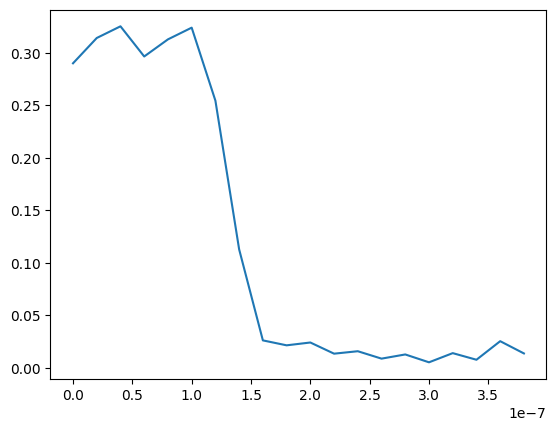

In [21]:
t_wait = data_object.depletion_times
state_cases = data_object.initial_state_case

probed_data = data_object.get_response(state_cases[0], probe_on = True, depletion_time = t_wait)

# print(probed_data)

unprobed_data = data_object.get_response(state_cases[0], probe_on = False, depletion_time = t_wait)

normalized_deviation = np.sqrt(np.mean(np.power(probed_data - unprobed_data,2),axis=1)) #/len(data_object.allxy_cases)

plt.plot(t_wait, normalized_deviation)
plt.show()

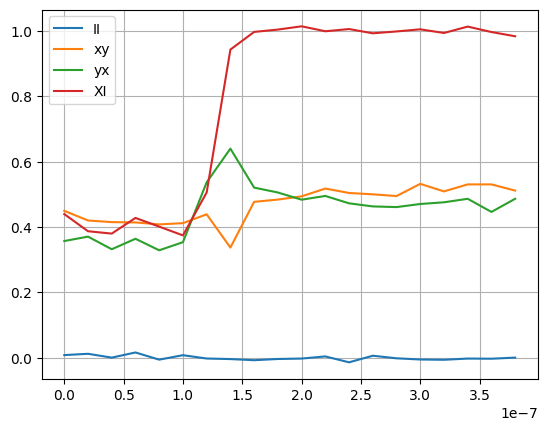

In [7]:
t_wait = data_object.depletion_times
state_cases = data_object.initial_state_case

data = data_object.get_response(state_cases[0], probe_on = True, depletion_time = t_wait)

II = data[:,0]
xy = data[:,1]
yx = data[:,2]
XI = data[:,3]


plt.plot(t_wait,II, label = "II")
plt.plot(t_wait,xy, label = "xy")
plt.plot(t_wait,yx, label = "yx")
plt.plot(t_wait,XI, label = "XI")
plt.grid()
plt.legend()
plt.show()

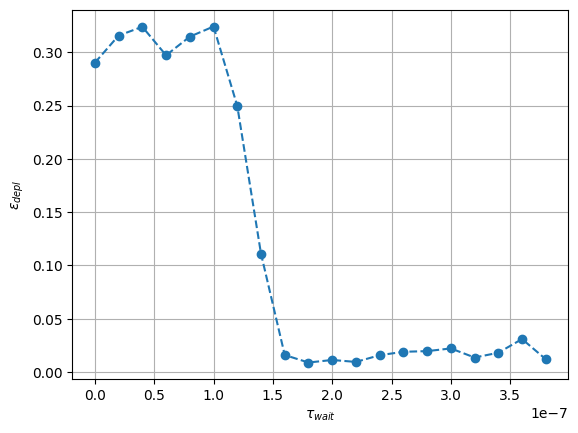

In [44]:
ideal_response = data_object.get_ideal_response(state_cases[0])

squared_diff_II = np.power(II-ideal_response[0],2)
squared_diff_xy = np.power(xy-ideal_response[1],2)
squared_diff_yx = np.power(yx-ideal_response[2],2)
squared_diff_XI = np.power(XI-ideal_response[3],2)

rms = np.sqrt((squared_diff_II+squared_diff_xy+squared_diff_yx+squared_diff_XI)/4)

plt.plot(t_wait,rms,ls='--', marker = 'o')
plt.xlabel(r'$\tau_{wait}$')
plt.ylabel(r'$\epsilon_{depl}$')
plt.grid()
plt.show()


In [9]:
def get_rms(tuid):
    dataset = load_dataset(tuid)
    dataset_bootstrap = DeserializeBootstrap(data=dataset)
    data_object: IPhotonDepletionContainer = object_factory.construct(dataset_bootstrap)

    t_wait = data_object.depletion_times
    state_cases = data_object.initial_state_case

    rms_list = []
    for case in state_cases:
        data = data_object.get_response(case, probe_on = True, depletion_time = t_wait)
        
        II = data[:,0]
        xy = data[:,1]
        yx = data[:,2]
        XI = data[:,3]
        
        ideal_response = data_object.get_ideal_response(case)
        
        squared_diff_II = np.power(II-ideal_response[0],2)
        squared_diff_xy = np.power(xy-ideal_response[1],2)
        squared_diff_yx = np.power(yx-ideal_response[2],2)
        squared_diff_XI = np.power(XI-ideal_response[3],2)
        
        rms_tmp = np.sqrt((squared_diff_II+squared_diff_xy+squared_diff_yx+squared_diff_XI)/4)

        rms_list.append(rms_tmp)

    rms0 = rms_list[0]
    rms1 = rms_list[1]

    return t_wait, rms0, rms1

def plot_rms(t_wait, rms0, rms1, qubit, save_fig = False):
    plt.title(qubit)
    plt.plot(t_wait, rms0, ls='--', marker = 'o', c = 'blue', label = r'0-state')
    plt.plot(t_wait, rms1, ls='--', marker = 'o', c= 'red', label = r'1-state')
    plt.legend()
    plt.xlabel(r'$\tau_{wait}$')
    plt.ylabel(r'$\epsilon_{depl}$')
    plt.grid()

    if save_fig:
        title = 'Photon depletion ' + qubit + '.png'
        plt.savefig(title)
            
    plt.show() 

def plot_cumsum(t_wait, cumsum0, cumsum1, qubit, break_point0, break_point1, save_fig = False):
    plt.title(qubit)
    plt.plot(t_wait, cumsum0, marker = 'o', c = 'blue', label = r'0-state')
    plt.plot(t_wait, cumsum1, marker = 'o', c= 'red', label = r'1-state')
    
    plt.vlines(break_point0, 0, max(np.max(cumsum0),np.max(cumsum1)), ls='--', color = 'blue') 
    plt.vlines(break_point1, 0, max(np.max(cumsum0),np.max(cumsum1)), ls='--', color = 'red') 
    
    plt.legend()
    plt.xlabel(r'$\tau_{wait}$')
    plt.ylabel(r'$\epsilon_{depl}$')
    plt.grid()

    if save_fig:
        title = 'Photon depletion cumsum' + qubit + '.png'
        plt.savefig(title)
            
    plt.show()

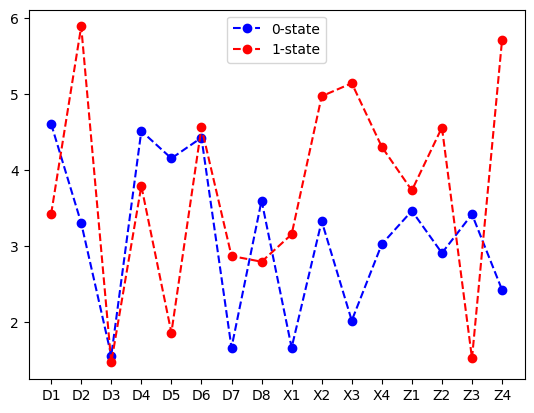

In [10]:
qubits = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'X1', 'X2', 'X3', 'X4', 'Z1', 'Z2', 'Z3', 'Z4']

integrated0 = []
integrated1 = []

for qubit in qubits:
    containing = 'Photon depletion ' + qubit

    tuid = get_latest_tuid(contains=containing)

    t_wait, rms0, rms1 = get_rms(tuid)
    # plot_rms(t_wait,rms0,rms1,qubit)
    integrated0.append(np.sum(rms0))
    integrated1.append(np.sum(rms1))

plt.plot(qubits, integrated0, ls='--', marker = 'o', c = 'blue', label = r'0-state')
plt.plot(qubits, integrated1, ls='--', marker = 'o', c= 'red', label = r'1-state')
plt.legend()
plt.show()
         
    

0.15824955746979255


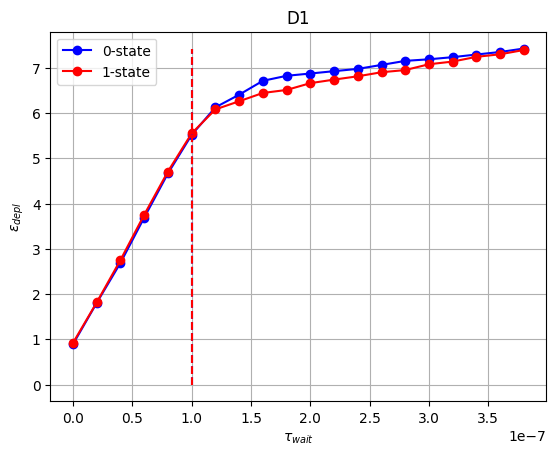

0.11628633038303082


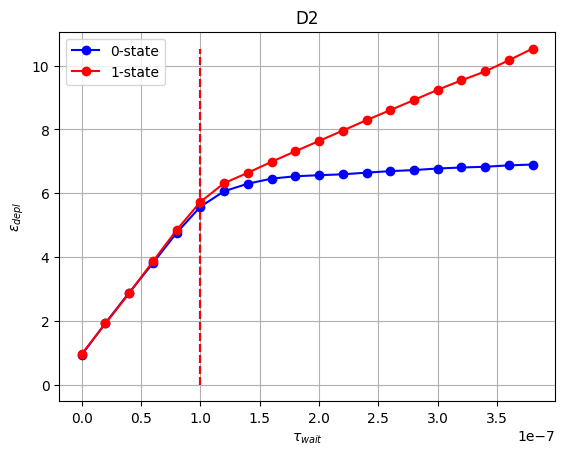

0.2331272732800628


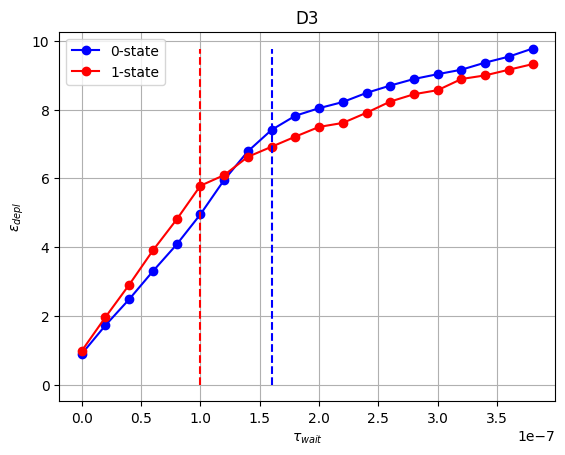

0.08155236545360862


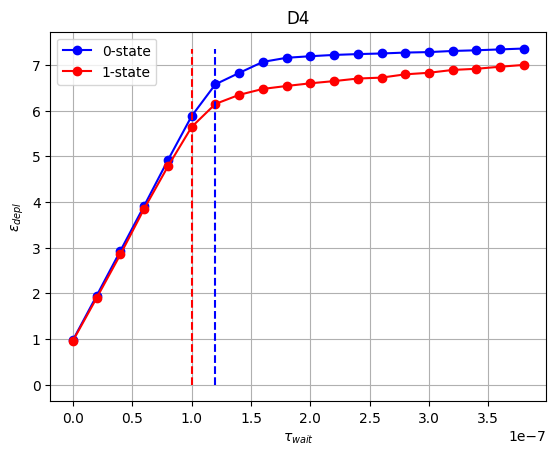

0.049163300358852205


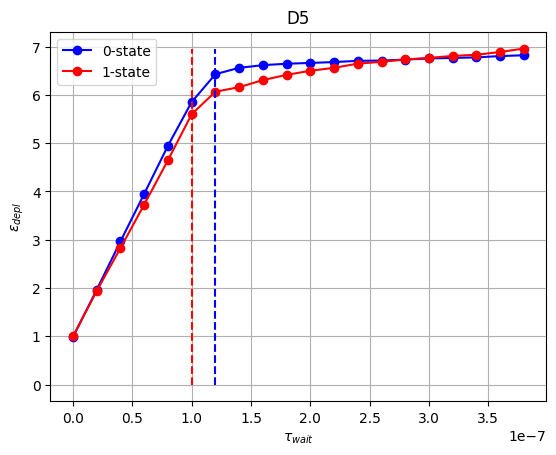

0.06908284577559219


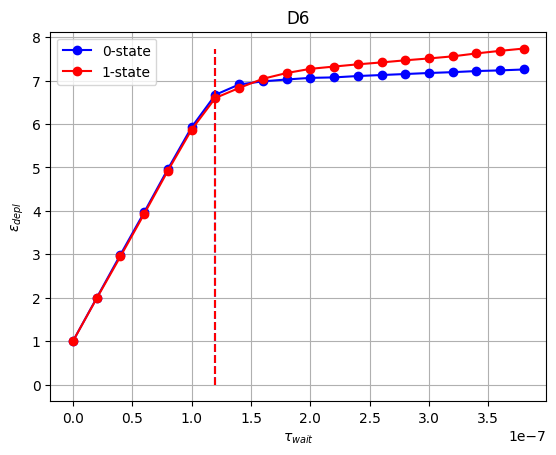

0.14794986412689617


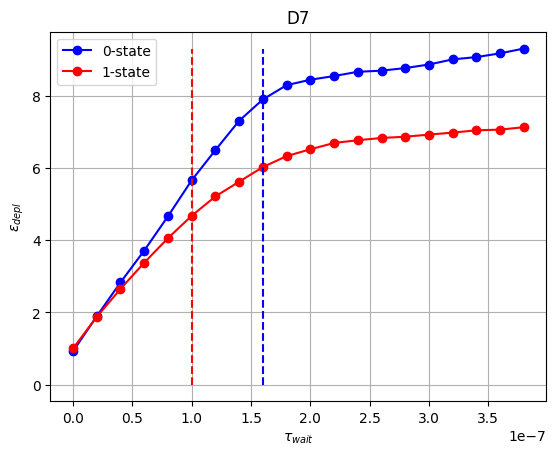

0.11747982320057858


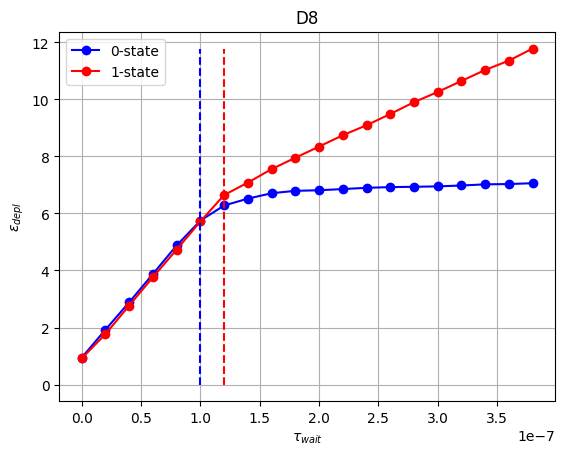

0.1571043737769834


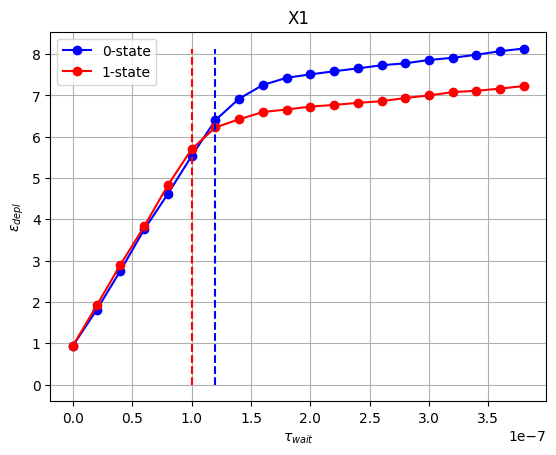

0.06740350339978998


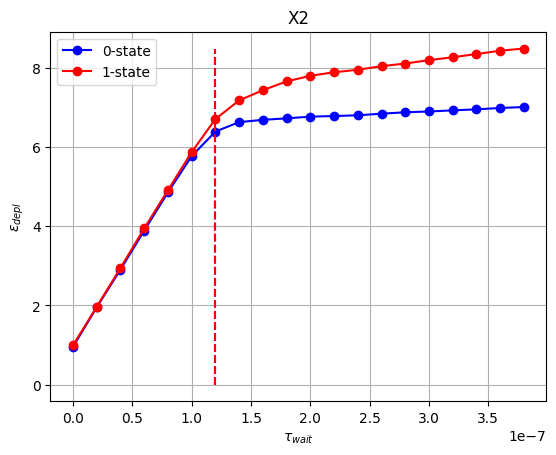

0.08883104137242352


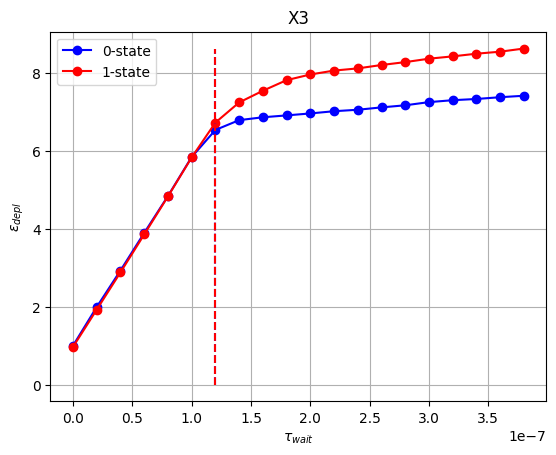

0.04978773997626572


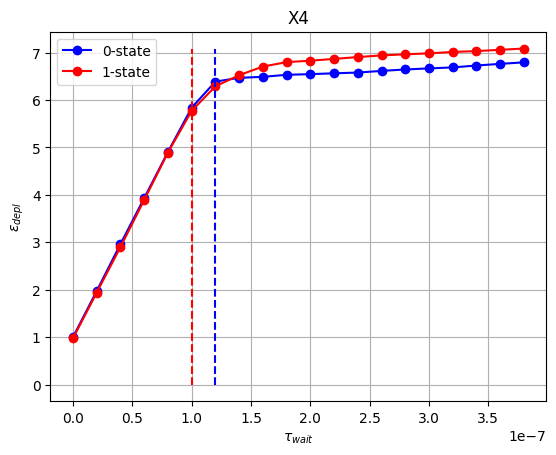

0.12752872243766042


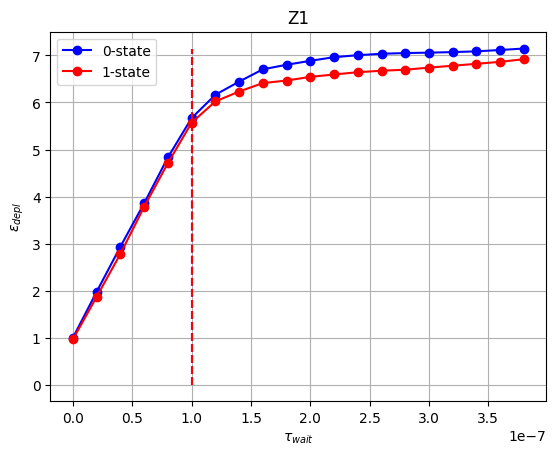

0.1409746122664136


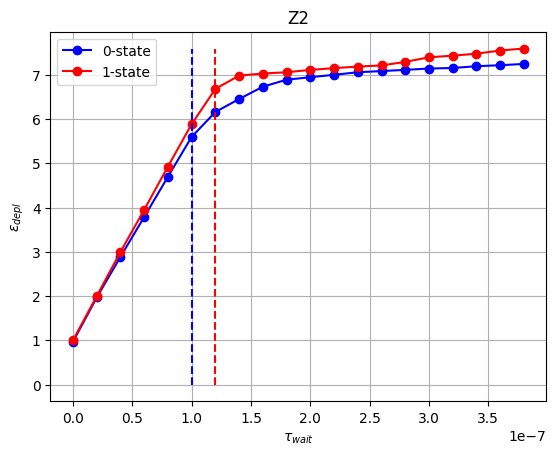

0.1111003327867729


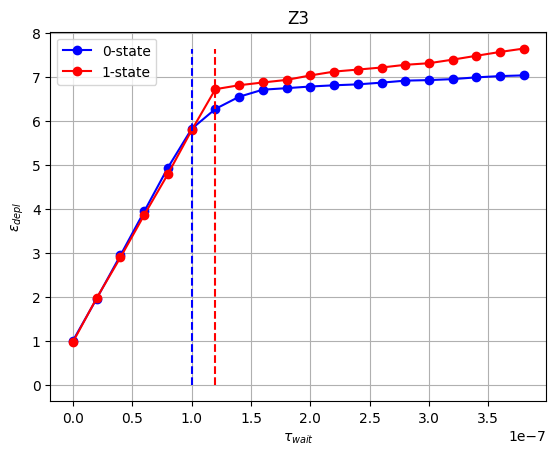

0.09663591838791923


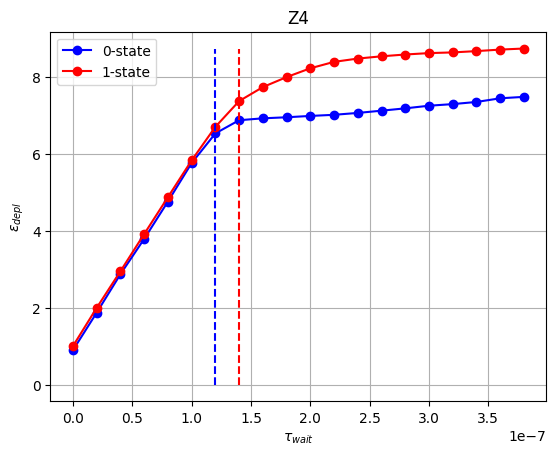

In [15]:
qubits = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'X1', 'X2', 'X3', 'X4', 'Z1', 'Z2', 'Z3', 'Z4']

integrated0 = []
integrated1 = []

for qubit in qubits:
    containing = 'Photon depletion ' + qubit

    tuid = get_latest_tuid(contains=containing)

    t_wait, rms0, rms1 = get_rms(tuid)

    # t_wait = t_wait[6:]
    # rms0 = rms0[6:]
    # rms1 = rms1[6:]

    normalized_rms0 = rms0/np.max(rms0)
    normalized_rms1 = rms1/np.max(rms1)
    
    cumsum0 = np.cumsum(normalized_rms0)
    cumsum1 = np.cumsum(normalized_rms1)

    dcumsum0 = np.gradient(cumsum0)
    ddcumsum0 = np.gradient(dcumsum0)

    dcumsum1 = np.gradient(cumsum1)
    ddcumsum1 = np.gradient(dcumsum1)

    arg0 = np.argmax(np.abs(ddcumsum0))
    arg1 = np.argmax(np.abs(ddcumsum1))
    
    break_point0 = t_wait[arg0]
    break_point1 = t_wait[arg1]

    avg_grad0 = np.mean(dcumsum0[arg0:])
    avg_grad1 = np.mean(dcumsum1[arg1:])

    print(avg_grad0)
    
    plot_cumsum(t_wait,cumsum0,cumsum1,qubit, break_point0, break_point1)

            
    
         

In [122]:
np.gradient([-2,1,2,5])

array([3., 2., 2., 3.])

In [34]:
x = np.flip(np.array([1,2,3]))

print(np.cumsum(x))

[3 5 6]
